In [184]:
# modified sta 141c project
# use yelp dataset and filtering methods to create recommendation system
import json 
import pandas as pd
import numpy as np
import os
import tarfile
import dask.dataframe as dd
import matplotlib.pyplot as plt
import plotly.express as px
from builtins import isinstance
import ast
import warnings
from joblib import parallel_backend
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
warnings.filterwarnings('ignore')
os.chdir('C:\\Users\\Rohan\\Downloads')

## Loading Data In

In [3]:
path = "C:\\Users\\Rohan\\Downloads\\yelp_dataset"
folder_path = "C:\\Users\\Rohan\\Downloads\\yelp extracted"

#with tarfile.open(path, 'r') as tar: # extract dataset
    #tar.extractall(path = folder_path)

business = dd.read_json(folder_path + '\\yelp_academic_dataset_business.json', lines = True) # get business ids along with identifying characteristics
reviews = dd.read_json(folder_path + '\\yelp_academic_dataset_review.json', lines = True)
business = business.compute()
reviews = reviews.compute()

In [92]:
philly = business[(business['city'] == 'Philadelphia') & (business['categories'].str.contains('Restaurant')) & (business['is_open'] == 1)] # get only open restaurants in philly from original dataset
philly.head()


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."
19,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,"{'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20..."
35,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,901 N Delaware Ave,Philadelphia,PA,19123,39.962582,-75.135657,3.5,65,1,"{'OutdoorSeating': 'True', 'RestaurantsPriceRa...","Eatertainment, Arts & Entertainment, Brewpubs,...","{'Monday': '0:0-0:0', 'Wednesday': '16:0-22:0'..."
82,ppFCk9aQkM338Rgwpl2F5A,Wawa,3604 Chestnut St,Philadelphia,PA,19104,39.954573,-75.194894,3.0,56,1,"{'Alcohol': 'u'none'', 'RestaurantsGoodForGrou...","Restaurants, Automotive, Delis, Gas Stations, ...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."


## Initial Plots

In [72]:
%matplotlib inline
fig = px.scatter_mapbox(philly, lat = 'latitude', lon = 'longitude', hover_name = 'name', hover_data=['address', 'stars', 'review_count'], custom_data=['address', 'stars', 'review_count']) # map out restaurants

fig.update_layout(mapbox_style = 'open-street-map', mapbox_center = {'lat': philly['latitude'].mean(), 'lon': philly['longitude'].mean()})
fig.show()

In [158]:
%matplotlib inline
philly['stars'] = philly['stars'].round()


ratings_chart = philly['stars'].value_counts()
star_bar = px.bar(ratings_chart, y = 'stars')

star_bar.update_layout(title = 'Star Counts', xaxis_title = 'Restaurant Star Rating', yaxis_title = 'Count')
star_bar.show()

## Processing Data

In [103]:
def extract_keys(attr, key):
    if attr == None:
        return "{}"
    if key in attr:
        return attr.pop(key)

# convert string to dictionary

def str_to_dict(attr):
    if attr != None:
        return ast.literal_eval(attr)
    else:
        return ast.literal_eval("{}")

In [135]:
philly['OutdoorSeating'] = philly.apply(lambda x: 
str_to_dict(extract_keys(x['attributes'], 'OutdoorSeating')), axis = 1)


philly['GoodforMeal'] = philly.apply(lambda x: 
str_to_dict(extract_keys(x['attributes'], 'GoodforMeal')), axis = 1)


philly['BusinessParking'] = philly.apply(lambda x: 
str_to_dict(extract_keys(x['attributes'], 'BusinessParking')), axis = 1)


philly['Ambience'] = philly.apply(lambda x: 
str_to_dict(extract_keys(x['attributes'], 'Ambience')), axis = 1)


philly['Music'] = philly.apply(lambda x: 
str_to_dict(extract_keys(x['attributes'], 'Music')), axis = 1)


philly['GoodForKids'] = philly.apply(lambda x: 
str_to_dict(extract_keys(x['attributes'], 'GoodForKids')), axis = 1)


philly['ByAppointment'] = philly.apply(lambda x: 
str_to_dict(extract_keys(x['attributes'], 'ByAppointment')), axis = 1)


philly['DogsAllowed'] = philly.apply(lambda x: 
str_to_dict(extract_keys(x['attributes'], 'DogsAllowed')), axis = 1)


philly['WheelchairAccessible'] = philly.apply(lambda x: 
str_to_dict(extract_keys(x['attributes'], 'WheelchairAccessible')), axis = 1).replace('{}')


In [160]:

philly_attributes = pd.concat([philly['attributes'].apply(pd.Series), 
philly['OutdoorSeating'].apply(pd.Series),
philly['GoodforMeal'].apply(pd.Series),
philly['BusinessParking'].apply(pd.Series),
philly['Ambience'].apply(pd.Series),
philly['Music'].apply(pd.Series),
philly['GoodForKids'].apply(pd.Series),
philly['ByAppointment'].apply(pd.Series),
philly['DogsAllowed'].apply(pd.Series),
philly['WheelchairAccessible'].apply(pd.Series),
], axis = 1)

attribute_dummies = pd.get_dummies(philly_attributes)
#attribute_dummies

#cat_dummies = pd.Series(philly['categories'].str.get_dummies(',')) # get dummy variables for categories

#philly_analysis = pd.concat([attribute_dummies, cat_dummies, philly[['name', 'stars']]], axis = 1)
cat_dummies = philly['categories'].str.get_dummies(',')


philly_analysis = pd.concat([philly[['name', 'stars']], attribute_dummies, cat_dummies], axis=1)

In [161]:
philly_analysis.head()

,name,stars,BusinessAcceptsCreditCards_False,BusinessAcceptsCreditCards_None,BusinessAcceptsCreditCards_True,RestaurantsPriceRange2_1,RestaurantsPriceRange2_2,RestaurantsPriceRange2_3,RestaurantsPriceRange2_4,RestaurantsPriceRange2_None,...,Trinidadian,Turkish,Uzbek,Vegan,Vegetarian,Venues & Event Spaces,Vietnamese,Wine Bars,Wineries,Wraps
3,St Honore Pastries,4.0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,Tuna Bar,4.0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,BAP,4.0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35,Craft Hall,4.0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
82,Wawa,3.0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Content-Based Filtering

In [164]:

x = philly_analysis.iloc[:,2:]
y = philly_analysis['stars']



x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 7)

knn = KNeighborsClassifier(n_neighbors = 10, n_jobs = -1)
knn.fit(x_train, y_train)

ktrain_score = knn.score(x_train, y_train)
ktest_score = knn.score(x_test, y_test)

print(f'knn train score {ktrain_score}')
print(f'knn test score {ktest_score}')

knn train score 0.7100319035802907
knn test score 0.6643059490084986


In [177]:
philly.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,BikeParking,Ambience,Music,GoodForKids,ByAppointment,DogsAllowed,WheelchairAccessible,RestaurantsReservation,GoodforMeal,BusinessParking
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,{},{},{},{},{},{},{},{},{},{}
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,...,{},{},{},{},{},{},{},{},{},{}
19,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.0,205,...,{},{},{},{},{},{},{},{},{},{}
35,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,901 N Delaware Ave,Philadelphia,PA,19123,39.962582,-75.135657,4.0,65,...,{},{},{},{},{},{},{},{},{},{}
82,ppFCk9aQkM338Rgwpl2F5A,Wawa,3604 Chestnut St,Philadelphia,PA,19104,39.954573,-75.194894,3.0,56,...,{},{},{},{},{},{},{},{},{},{}


## Collaborative Filtering (SVD)

In [178]:
philly_reviews = reviews[['user_id', 'business_id', 'stars', 'date']] # get info needed for svd
res_df = philly[['business_id', 'name', 'address']]

philly_svd = pd.merge(philly_reviews, res_df, on = 'business_id')
philly_svd.head()

,user_id,business_id,stars,date,name,address
0,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,2015-01-04 00:01:03,Zaika,2481 Grant Ave
1,kSMOJwJXuEUqzfmuFncK4A,kxX2SOes4o-D3ZQBkiMRfA,2,2014-07-13 17:25:47,Zaika,2481 Grant Ave
2,mqBWACmaHflW4eh_Ofp16Q,kxX2SOes4o-D3ZQBkiMRfA,5,2010-08-20 19:16:04,Zaika,2481 Grant Ave
3,Z-xgVb4nM42943m2wbBkFw,kxX2SOes4o-D3ZQBkiMRfA,5,2017-01-02 14:25:26,Zaika,2481 Grant Ave
4,2SEoXb6r6hPKrl9V9VzBgA,kxX2SOes4o-D3ZQBkiMRfA,5,2015-07-28 17:15:20,Zaika,2481 Grant Ave


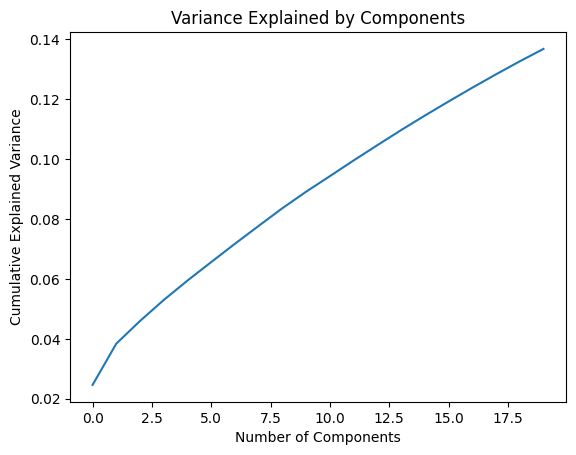

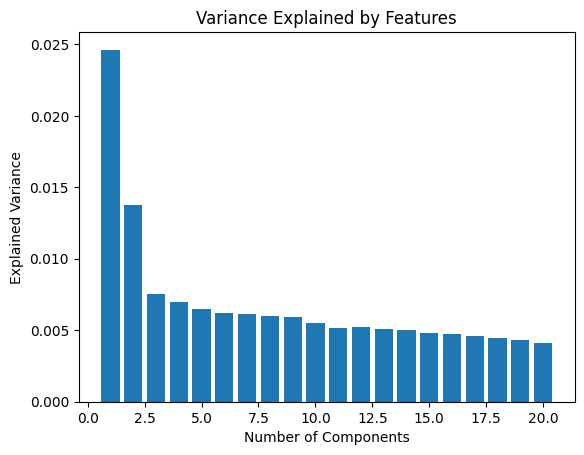

In [189]:
%matplotlib inline
s_mat = philly_svd.pivot_table(values = 'stars', index = 'user_id', columns = 'name', fill_value = 0)
s_mat_vals = pivot_table.values.T
svd = TruncatedSVD(n_components = 20)

with parallel_backend('multiprocessing', n_jobs = -1): # runs SVD on all processes available 
    #u,s,vt = randomized_svd(A, n_components = 800, random_state = 21)
    res_matrix = svd.fit_transform(s_mat_vals) 
    corr_matrix = np.corrcoef(res_matrix)
    usig = res_matrix # is actually u * sigma 
    s = svd.singular_values_
    vt = svd.components_
    ex_var_rat = svd.explained_variance_ratio_

plt.plot(np.cumsum(ex_var_rat))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Explained by Components')
plt.show()

plt.bar(range(1, len(ex_var_rat) + 1), ex_var_rat)
plt.ylabel('Explained Variance')
plt.xlabel('Number of Components')
plt.title('Variance Explained by Features')
plt.show()

reduced_philly = philly[['name', 'address', 'city', 'state', 'postal_code', 'stars', 'review_count']] # get reduced dataset for recommendation function

In [213]:
def top_restaurants(restaurant, n = 10, correlation_factor = 0.97):
    """
    Function returns top n correlated restaurants with given restaurant name. Can adjust Pearson correlation factor as needed in order to return more restaurants.
    """
    selected_restaurant = int(list(s_mat.columns).index(str(restaurant))) # get index of restaurant from matrix
    recommendations = s_mat.columns[(corr_matrix[selected_restaurant] < 1.0) & (corr_matrix[selected_restaurant] > correlation_factor)].sort_values(ascending = False).values.tolist() # returns highest correlated restaurants with restaurant in index of correlation matrix
    
    df = pd.DataFrame(recommendations)
    df.columns = ['name']
    res_df = pd.merge(reduced_philly, df, on = 'name', how = 'inner').drop_duplicates(keep = False) # create dataframe that contains the info about the recommended restaurants
    res_df = res_df.drop_duplicates() # creating dataframe with recommended restaurants
    res_df = res_df.rename({'bus_stars': 'stars'}, axis = 1)
    restaurants = res_df.sort_values('name').drop_duplicates(subset = ['address']) # drop duplicated instances of restaurants in recommendation dataframe
    
    
    
    return restaurants[0:n].sort_values(by = ['stars'], ascending = True) 

top_restaurants('Tuna Bar')

,name,address,city,state,postal_code,stars,review_count
11,Alpen Rose,116 S 13th St,Philadelphia,PA,19107,4.0,153
10,Barcelona Wine Bar Passyunk,1709 E Passyunk Ave,Philadelphia,PA,19148,4.0,608
3,Bloomsday Cafe,414 S 2nd St,Philadelphia,PA,19147,4.0,73
7,Burrata,1247 S 13th St,Philadelphia,PA,19147,4.0,155
2,Emmy Squared - Queen Village,632 S 5th St,Philadelphia,PA,19147,4.0,177
9,Harper's Garden,31 S 18th St,Philadelphia,PA,19103,4.0,516
6,JG SkyHigh,"1 N 19th St, Fl 60",Philadelphia,PA,19103,4.0,129
4,Kei Sushi Restaurant,1711 South St,Philadelphia,PA,19146,4.0,157
1,Libertine Restauraunt,261 S 13th St,Philadelphia,PA,19107,4.0,117
5,Royal Boucherie,52 S 2nd St,Philadelphia,PA,19106,4.0,228
